# 🧠 GNN City Simulation — All-in-One Notebook

This notebook demonstrates how to model and analyze a smart city system using **Graph Neural Networks (GNNs)**. It includes everything you need to simulate a miniature world of city landmarks (like housing, water sources, power plants, etc.), define production/consumption relationships, and visualize flows.

---

## 📦 What This Notebook Does

✅ **Generates a mock city graph** with nodes and edges:  
- Nodes are city landmarks with specific roles (e.g., factories, mines, farms).  
- Edges represent physical infrastructure (e.g., roads), with distances.

✅ **Defines resource requirements**:  
- Housing needs water, energy, and goods.  
- Factories need minerals and materials.  
- These dependencies are stored as directional resource flows.

✅ **Uses a GNN (Graph Convolutional Network)** to compute embeddings:  
- Each landmark is assigned a learned vector based on its type, neighbors, and graph context.

✅ **Visualizes**:  
- City infrastructure (gray dashed roads)  
- Resource flows (black arrows with quantity/type)  
- Landmark types (color-coded nodes)  

✅ **Ensures realism**:  
- Every node is connected  
- Consumers are guaranteed to be linked to valid producers

---

## 🎯 Learning Goals

- Represent real-world systems as graphs  
- Combine structured tabular and network data  
- Use PyTorch Geometric to build and run a GCN  
- Visualize and interpret multi-type graphs  
- Explore GNN applications in city planning, logistics, and optimization

---

## 🚀 Ready to Use

This notebook is self-contained and ideal for:
- Teaching graph ML concepts  
- Rapid experimentation  
- Student challenges and course projects

No additional files are needed — just run all cells!



# Load libraries and functions

In [1]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
  Obtaining dependency information for torch-geometric from https://files.pythonhosted.org/packages/03/9f/157e913626c1acfb3b19ce000b1a6e4e4fb177c0bc0ea0c67ca5bd714b5a/torch_geometric-2.6.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.3/638.3 kB 818.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 970.3/970.3 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.6/571.6 kB 726.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.8/200.8 kB 407.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.5 MB/s eta 0:00:0000:0100:01


In [2]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import os


/Users/ignasi/anaconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/ignasi/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/ignasi/anaconda3/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): symbol not found in flat namespace '__ZN3c1017RegisterOperatorsD1Ev'
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ignasi/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: dlopen(/Users/ignasi/anaconda3/lib/python3.11/site-packages/torch_cluster/_

# Data Generation Function

In [3]:
def generate_mock_data(output_dir="data", n_landmarks=10, edge_prob=0.3):
    import os
    import pandas as pd
    import random
    import numpy as np

    random.seed(42)
    np.random.seed(42)

    os.makedirs(output_dir, exist_ok=True)

    landmark_types = {
        "housing": {"citizens": (500, 2000), "needs": ["water", "energy", "goods"]},
        "water_source": {"water_prod": (5000, 15000)},
        "power_plant": {"energy_prod": (3000, 10000)},
        "farm": {"materials_prod": (200, 500)},
        "mine": {"minerals_prod": (100, 300)},
        "factory": {"goods_prod": (100, 400), "needs": ["materials", "minerals"]},
    }

    # Create landmarks
    nodes = []
    for i in range(n_landmarks):
        l_type = random.choice(list(landmark_types.keys()))
        attrs = {"id": i, "type": l_type}
        for k, v in landmark_types[l_type].items():
            if k == "needs":
                attrs[k] = ",".join(v)
            else:
                attrs[k] = random.randint(*v)
        nodes.append(attrs)

    node_df = pd.DataFrame(nodes)
    for col in ["citizens", "water_prod", "energy_prod", "materials_prod", "minerals_prod", "goods_prod", "needs"]:
        if col not in node_df.columns:
            node_df[col] = 0 if "prod" in col or col == "citizens" else ""

    # Create requirements and ensure connectivity
    edges = []
    requirements = []
    for _, row in node_df.iterrows():
        needs_raw = str(row["needs"])
        if needs_raw and needs_raw != "0":
            for need in needs_raw.split(","):
                prod_col = f"{need}_prod"
                if prod_col in node_df.columns:
                    candidates = node_df[(node_df[prod_col] > 0) & (node_df["id"] != row["id"])]
                    if not candidates.empty:
                        producer = candidates.sample(1).iloc[0]
                        if not any((e[0] == row["id"] and e[1] == producer["id"]) or
                                   (e[0] == producer["id"] and e[1] == row["id"]) for e in edges):
                            dist = round(random.uniform(1.0, 5.0), 2)
                            edges.append((row["id"], producer["id"], dist))
                        requirements.append({
                            "from_id": producer["id"],
                            "to_id": row["id"],
                            "resource_type": need,
                            "quantity": random.randint(50, 300)
                        })

    # Add random edges
    for i in range(n_landmarks):
        for j in range(i + 1, n_landmarks):
            if random.random() < edge_prob and not any((e[0] == i and e[1] == j) or (e[0] == j and e[1] == i) for e in edges):
                dist = round(random.uniform(1.0, 5.0), 2)
                edges.append((i, j, dist))

    # Ensure all nodes are connected at least once
    connected_nodes = set()
    for edge in edges:
        connected_nodes.add(edge[0])
        connected_nodes.add(edge[1])

    all_nodes = set(node_df["id"].tolist())
    unconnected = all_nodes - connected_nodes

    for node in unconnected:
        possible_targets = list(all_nodes - {node})
        if possible_targets:
            target = random.choice(possible_targets)
            dist = round(random.uniform(1.0, 5.0), 2)
            edges.append((node, target, dist))

    # Save to CSV
    edge_df = pd.DataFrame(edges, columns=["source", "target", "distance"])
    req_df = pd.DataFrame(requirements)

    node_df.to_csv(f"{output_dir}/landmark_features.csv", index=False)
    edge_df.to_csv(f"{output_dir}/city_graph.csv", index=False)
    req_df.to_csv(f"{output_dir}/requirements.csv", index=False)


# Generate and Visualize data

In [4]:
generate_mock_data()


In [5]:
features = pd.read_csv("data/landmark_features.csv")
edges = pd.read_csv("data/city_graph.csv")
requirements = pd.read_csv("data/requirements.csv")


Landmark Features Dataset:

* Landmark ID: Identifier of the landmark
* Type: type of landmark ("factory", "housing", "water_source", "farm", "power_plant", ...)
* Goods: Elements produced at the landmark
* Needs: Elements needed at the landmark
* Citizens: People living (for housing)
* X_prod: Amount of elements "X" produced (for goods or energy sources)

In [6]:
!head -n 12 data/landmark_features.csv

id,type,goods_prod,needs,citizens,water_prod,materials_prod,minerals_prod,energy_prod
0,factory,157.0,"materials,minerals",,,,,0
1,housing,,"water,energy,goods",1063.0,,,,0
2,water_source,,,,8657.0,,,0
3,water_source,,,,6679.0,,,0
4,factory,379.0,"materials,minerals",,,,,0
5,housing,,"water,energy,goods",1709.0,,,,0
6,farm,,,,,216.0,,0
7,housing,,"water,energy,goods",691.0,,,,0
8,water_source,,,,8811.0,,,0
9,mine,,,,,,254.0,0


City Graph Dataset:

* Adjacency Matrix: "ID 1", "ID2", "Distance"

In [ ]:
!head data/city_graph.csv

source,target,distance
0,6,1.11
0,9,3.86
1,2,3.18
1,4,2.8
4,6,4.24
4,9,4.04
5,3,3.79
5,0,2.11
7,3,4.83


Requirements Dataset:

* "From" ID: Origin landmark
* "To" ID: Destination landmark
* "Material": Elements to transport
* "Quantity": Amounts required

In [ ]:
!head data/requirements.csv

from_id,to_id,resource_type,quantity
6,0,materials,100
9,0,minerals,229
2,1,water,106
4,1,goods,121
6,4,materials,51
9,4,minerals,90
3,5,water,137
0,5,goods,105
3,7,water,136


In [ ]:
print(requirements)

   from_id  to_id resource_type  quantity
0        6      0     materials       100
1        9      0      minerals       229
2        2      1         water       106
3        4      1         goods       121
4        6      4     materials        51
5        9      4      minerals        90
6        3      5         water       137
7        0      5         goods       105
8        3      7         water       136
9        4      7         goods       147


# GNN + Problem configuration

## Shape the Data into GNN-compliant data

### Generate NODE properties from Landmarks

In [ ]:
type_map = {t: i for i, t in enumerate(features['type'].unique())}
features['type_id'] = features['type'].map(type_map)
node_feats = features[['type_id', 'citizens', 'water_prod', 'energy_prod',
                       'materials_prod', 'minerals_prod', 'goods_prod']].fillna(0)
x = torch.tensor(node_feats.values, dtype=torch.float)


### Generate EDGE properties from City Graph

In [ ]:
edge_index = torch.tensor(edges[['source', 'target']].values.T, dtype=torch.long)
rev_index = edge_index[[1, 0], :]
edge_index = torch.cat([edge_index, rev_index], dim=1)

weights = torch.tensor([1.0 / d for d in edges['distance']], dtype=torch.float)
weights = torch.cat([weights, weights], dim=0)


### Compile the data NODE-EDGE and the GNN to admit that data

In [ ]:
data = Data(x=x, edge_index=edge_index, edge_attr=weights)


In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_weight)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x


In [ ]:
model = GNN(in_channels=x.shape[1], hidden_channels=16, out_channels=8)
model.eval()
with torch.no_grad():
    out = model(data)

node_importance = out.norm(dim=1)
print("Node importance (embedding norms):")
print(node_importance)


Node importance (embedding norms):
tensor([1053.6425, 2630.2607, 3085.3369, 2527.3960, 1970.4847, 2515.0132,
         918.1362, 2427.4214, 2548.8447, 2069.6230])


### Visualize the Data

In [ ]:
def visualize_network (features, edges):
    G = nx.DiGraph()
    G.add_nodes_from(features['id'].tolist())

    # Mixed visualization with flow + infrastructure
    G = nx.DiGraph()
    G.add_nodes_from(features['id'].tolist())

    # Label and color by type
    labels = {row['id']: row['type'] for _, row in features.iterrows()}
    type_colors = {typ: i for i, typ in enumerate(features['type'].unique())}
    node_colors = [type_colors[labels[n]] for n in G.nodes]

    # Add all infrastructure edges as dashed undirected links
    infra_edges = [(row['source'], row['target']) for _, row in edges.iterrows()]
    G.add_edges_from(infra_edges)

    # Add resource requirement edges as directed arrows with labels
    edge_labels = {}
    for _, row in requirements.iterrows():
        G.add_edge(row['from_id'], row['to_id'])
        edge_labels[(row['from_id'], row['to_id'])] = f"{row['resource_type']}: {row['quantity']}"

    # Layout and draw
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Paired, node_size=700)
    nx.draw_networkx_labels(G, pos, labels=labels)

    # Draw undirected infrastructure (dashed, light gray)
    nx.draw_networkx_edges(G, pos, edgelist=infra_edges, style="dashed", edge_color='lightgray')

    # Draw requirement flows (directed arrows)
    requirement_edges = [(r['from_id'], r['to_id']) for _, r in requirements.iterrows()]
    nx.draw_networkx_edges(G, pos, edgelist=requirement_edges, edge_color='black', arrows=True, arrowsize=20)

    # Add resource labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("City Graph with Roads (gray) and Resource Flows (arrows)")
    plt.show()


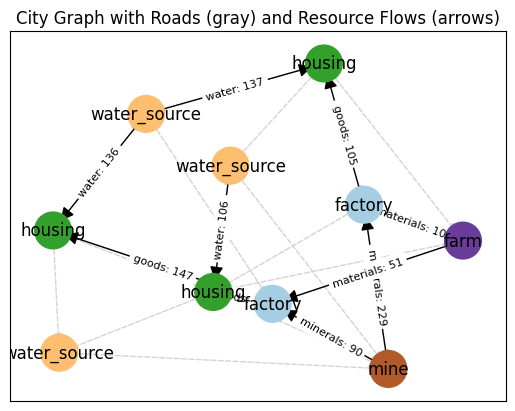

In [ ]:
visualize_network(features, edges)

# Data and Problem Interpretation

## 🧠 Interpreting the Graph

### 🔹 Dashed Gray Lines = Roads
- These come from `edges.csv`, representing **physical connections** between landmarks (e.g., roads or pipelines).
- They form the **infrastructure graph** — used by the GNN to learn how resources can travel.
- These are **undirected** (bidirectional use assumed).

### 🔸 Black Arrows = Resource Flows
- These are derived from `requirements.csv`, showing **who needs what**.
- Each arrow is directed: from a **producer** to a **consumer**.
- The label includes the **resource type** (e.g., water, minerals) and the **quantity** requested.

---

## 🧠 What Is the Role of the GNN?

The Graph Neural Network (GNN) computes an **embedding** (a learned vector) for each node, capturing:
- The node’s **features** (type, production levels, etc.),
- Its **position in the network** (who it's connected to),
- The **edge weights** (e.g., inverse distance, used to favor closer nodes).

These embeddings encode **contextual roles** of each node — e.g., is it a producer, a hub, a bottleneck?

---

## 🧠 What Could You Use the GNN For?

Here are some ideas for next steps or assignments:

### ✅ Predict Fulfillment
- Train a classifier on top of the GNN to predict whether a node's resource needs are **fully met**, **partially met**, or **unmet**.

### ✅ Rank Node Criticality
- Simulate node removal (e.g., a power plant goes offline) and observe how embeddings or connectivity shift.
- Use embedding norms or centrality metrics as **importance scores**.

### ✅ Route Optimization
- Extend edge weights with real costs (e.g., traffic, pollution) and train the GNN to recommend **optimal transfer routes**.

### ✅ Clustering / Community Detection
- Group nodes based on learned embeddings to identify **functional clusters** (e.g., an industrial area vs. residential).

### ✅ Temporal Dynamics (Advanced)
- Add a time dimension (day/night production, peaks) and use a **temporal GNN** to simulate real-world city operations.

---

Feel free to experiment with these extensions or define your own challenge based on the GNN outputs!


# Train a GNN to use the Data

## Creation of the Scenario

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd

In [ ]:
# Define a simple city graph (nodes: landmarks, edges: connections)
features = [
    {"id": 0, "type": "factory", "goods_prod": 157.0, "needs": "materials,minerals", "citizens": None, "water_prod": None, "materials_prod": None, "minerals_prod": None, "energy_prod": 0},
    {"id": 1, "type": "housing", "goods_prod": None, "needs": "water,energy,goods", "citizens": 1063.0, "water_prod": None, "materials_prod": None, "minerals_prod": None, "energy_prod": 0},
    {"id": 2, "type": "water_source", "goods_prod": None, "needs": None, "citizens": None, "water_prod": 8657.0, "materials_prod": None, "minerals_prod": None, "energy_prod": 0},
    {"id": 3, "type": "water_source", "goods_prod": None, "needs": None, "citizens": None, "water_prod": 6679.0, "materials_prod": None, "minerals_prod": None, "energy_prod": 0},
    {"id": 4, "type": "factory", "goods_prod": 379.0, "needs": "materials,minerals", "citizens": None, "water_prod": None, "materials_prod": None, "minerals_prod": None, "energy_prod": 0},
    {"id": 5, "type": "housing", "goods_prod": None, "needs": "water,energy,goods", "citizens": 1709.0, "water_prod": None, "materials_prod": None, "minerals_prod": None, "energy_prod": 0},
    {"id": 6, "type": "farm", "goods_prod": None, "needs": None, "citizens": None, "water_prod": None, "materials_prod": 216.0, "minerals_prod": None, "energy_prod": 0},
    {"id": 7, "type": "housing", "goods_prod": None, "needs": "water,energy,goods", "citizens": 691.0, "water_prod": None, "materials_prod": None, "minerals_prod": None, "energy_prod": 0},
    {"id": 8, "type": "water_source", "goods_prod": None, "needs": None, "citizens": None, "water_prod": 8811.0, "materials_prod": None, "minerals_prod": None, "energy_prod": 0},
    {"id": 9, "type": "mine", "goods_prod": None, "needs": None, "citizens": None, "water_prod": None, "materials_prod": None, "minerals_prod": 254.0, "energy_prod": 0},
]

features = pd.DataFrame(features)
#print(features)

type_map = {t: i for i, t in enumerate(features['type'].unique())}
features['type_id'] = features['type'].map(type_map)
node_feats = features[['type_id', 'citizens', 'water_prod', 'energy_prod',
                       'materials_prod', 'minerals_prod', 'goods_prod']].fillna(0)
x = torch.tensor(node_feats.values, dtype=torch.float)


In [ ]:
# source  target  distance
edges = [
    [0, 6, 1.11],
    [0, 9, 3.86],
    [1, 2, 3.18],
    [1, 4, 2.80],
    [4, 6, 4.24],
    [4, 9, 4.04],
    [5, 3, 3.79],
    [5, 0, 2.11],
    [7, 3, 4.83],
    [7, 4, 1.41],
    [0, 1, 4.39],
    [1, 6, 1.91],
    [1, 7, 1.32],
    [1, 8, 1.40],
    [1, 9, 3.54],
    [2, 5, 2.07],
    [2, 9, 3.92],
    [3, 4, 2.52],
    [5, 6, 4.77],
    [7, 8, 1.99],
    [8, 9, 3.34]
]
edges = pd.DataFrame(edges)
edges.columns = ['source', 'target', 'distance']

edge_index = torch.tensor(edges[['source', 'target']].values.T, dtype=torch.long)
rev_index = edge_index[[1, 0], :]
edge_index = torch.cat([edge_index, rev_index], dim=1)

weights = torch.tensor([1.0 / d for d in edges['distance']], dtype=torch.float)
weights = torch.cat([weights, weights], dim=0)

In [ ]:
# Define requirements (just for info/debugging, not yet used by the GNN)
requirements = [
    {"from_id": 6, "to_id": 0, "resource_type": "materials", "quantity": 100},
    {"from_id": 9, "to_id": 0, "resource_type": "minerals", "quantity": 229},
    {"from_id": 2, "to_id": 1, "resource_type": "water", "quantity": 106},
    {"from_id": 4, "to_id": 1, "resource_type": "goods", "quantity": 121},
    {"from_id": 6, "to_id": 4, "resource_type": "materials", "quantity": 51},
    {"from_id": 9, "to_id": 4, "resource_type": "minerals", "quantity": 90},
    {"from_id": 3, "to_id": 5, "resource_type": "water", "quantity": 137},
    {"from_id": 0, "to_id": 5, "resource_type": "goods", "quantity": 105},
    {"from_id": 3, "to_id": 7, "resource_type": "water", "quantity": 136},
    {"from_id": 4, "to_id": 7, "resource_type": "goods", "quantity": 147},
]
requirements = pd.DataFrame(requirements)

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_weight)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [ ]:
# Data Compilation
data = Data(x=x, edge_index=edge_index, edge_attr=weights)
model = GNN(in_channels=x.shape[1], hidden_channels=16, out_channels=8)

model.eval()
with torch.no_grad():
    out = model(data)

In [ ]:
print("Output node embeddings (each node has a 3D vector):")
print(out)

Output node embeddings (each node has a 3D vector):
tensor([[ 295.8575,  299.6250, -390.2595, -297.0040,  190.1328,  -79.2766,
            3.3500,  174.2584],
        [ 750.4222,  301.2884, -500.2173, -779.1451,  540.2883, -144.9733,
            4.2087,  610.6088],
        [ 879.1474,  285.2750, -530.4888, -925.5042,  665.3020, -192.2864,
           -2.6560,  756.9499],
        [ 726.1966,  222.8486, -403.1265, -750.1625,  517.1655, -116.9236,
            8.2660,  603.5883],
        [ 551.8876,  219.4340, -358.3135, -588.7949,  405.9086,  -89.1589,
            6.3813,  465.4744],
        [ 698.1617,  338.4983, -550.2859, -751.8951,  544.9579, -179.9585,
           -3.8365,  591.3062],
        [ 253.8703,  283.4755, -360.1791, -253.1029,  157.0334,  -66.2539,
            4.2893,  139.1280],
        [ 677.3234,  242.2922, -422.9308, -727.9068,  516.4683, -129.7476,
            2.1150,  591.1791],
        [ 736.1813,  221.0442, -412.0684, -759.8441,  532.0502, -136.2402,
            3.004

In [ ]:
node_importance = out.norm(dim=1)
print("Node importance (embedding norms):")
print(node_importance)


Node importance (embedding norms):
tensor([ 700.4521, 1482.2220, 1744.9467, 1395.6346, 1103.2758, 1466.0128,
         622.1115, 1363.5477, 1421.0026, 1148.4847])


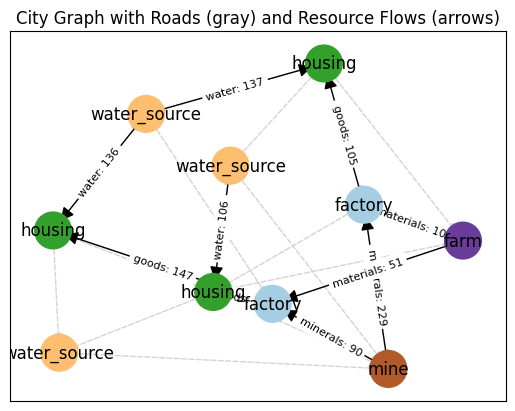

In [ ]:
visualize_network(features, edges)

In [ ]:
# You can then use the output embeddings to cluster nodes, match supply-demand, or optimize paths.
# For example: node 0 (housing) may embed close to nodes that satisfy its needs.

# Next steps for students:
# - Add more node types and features
# - Include resource flow prediction or optimization
# - Incorporate requirements into a custom loss function
# - Use edge attributes (e.g., distance or capacity)
# - Visualize the graph and embedding with networkx or matplotlib

## Example with connections (simple version)

In [ ]:
# Get final node embeddings from the trained (or untrained) GNN
model.eval()
with torch.no_grad():
    embeddings = model(data)  # shape [num_nodes, emb_dim]

In [ ]:
def check_resource(resource):
  supply_nodes = features[features[f"{resource}_prod"].fillna(0) > 0].index.tolist()
  demand_nodes = features[features['needs'].fillna('').str.contains(resource)].index.tolist()

  # Prepare output: scores for each (supply, demand) pair
  flows = []

  for s in supply_nodes:
      for d in demand_nodes:
          # Embedding-based similarity (e.g., dot product)
          sim_score = torch.dot(embeddings[s], embeddings[d]).item()

          # Get distance between s and d (or large penalty if no edge)
          match = edges[((edges['source'] == s) & (edges['target'] == d)) |
                        ((edges['source'] == d) & (edges['target'] == s))]
          if match.empty:
              continue  # or assign a large cost
          distance = match['distance'].values[0]
          inv_dist = 1 / distance

          # Final score (you can weight similarity vs distance differently)
          final_score = sim_score * inv_dist

          flows.append({"from": s, "to": d, "score": final_score})

  # Sort by score
  flows = sorted(flows, key=lambda x: -x["score"])
  return flows

In [ ]:
# Identify supply and demand nodes
resource = "materials"
flows = check_resource(resource)

# Print top suggested flows
#print("Top suggested flows for", resource)
#for f in flows[:10]:
for f in flows:
    print(f"Send {resource} from {f['from']} to {f['to']} (score: {f['score']:.2f})")


Send materials from 6 to 0 (score: 392026.91)
Send materials from 6 to 4 (score: 145007.31)


In [ ]:
# Identify supply and demand nodes
resource = "water"
flows = check_resource(resource)

# Print top suggested flows
#print("Top suggested flows for", resource)
#for f in flows[:10]:
for f in flows:
    print(f"Send {resource} from {f['from']} to {f['to']} (score: {f['score']:.2f})")


Send water from 8 to 1 (score: 1500453.57)
Send water from 2 to 5 (score: 1228463.41)
Send water from 8 to 7 (score: 973002.20)
Send water from 2 to 1 (score: 811844.03)
Send water from 3 to 5 (score: 535109.07)
Send water from 3 to 7 (score: 393690.22)


## Full example with quantities

In [ ]:
# Use GNN to get node embeddings
model.eval()
with torch.no_grad():
    embeddings = model(data)

In [ ]:
def check_supplies (resource):
    # Get only relevant requirements for this resource
    relevant_requirements = requirements[requirements['resource_type'] == resource]

    # Collect flow scores
    flow_scores = []

    for _, row in relevant_requirements.iterrows():
        to_id = row['to_id']
        quantity_needed = row['quantity']

        # Find all possible suppliers of this resource
        possible_sources = features[features[f"{resource}_prod"].fillna(0) > 0].index.tolist()

        scores = []
        for from_id in possible_sources:
            # Skip if no distance info
            match = edges[((edges['source'] == from_id) & (edges['target'] == to_id)) |
                          ((edges['source'] == to_id) & (edges['target'] == from_id))]
            if match.empty:
                continue
            distance = match['distance'].values[0]
            inv_dist = 1 / distance

            # GNN-based similarity
            score = torch.dot(embeddings[from_id], embeddings[to_id]).item() * inv_dist
            scores.append((from_id, score))

        if not scores:
            continue

        # Normalize scores
        scores_tensor = torch.tensor([s[1] for s in scores])
        probs = F.softmax(scores_tensor, dim=0).numpy()

        for i, (from_id, _) in enumerate(scores):
            flow_amount = probs[i] * quantity_needed
            flow_scores.append({
                "from": features.loc[features['id'] == from_id, 'type'].iloc[0] + ' (' + str(from_id) + ') ',
                "to": features.loc[features['id'] == to_id, 'type'].iloc[0] + ' (' + str(to_id) + ') ',
                "resource": resource,
                "quantity": flow_amount
            })

    # Create DataFrame of flows
    flow_df = pd.DataFrame(flow_scores)
    return flow_df

In [ ]:
flow_1 = check_supplies("water")
flow_2 = check_supplies("materials")
flow_3 = check_supplies("minerals")
flow_4 = check_supplies("goods")

flow = pd.concat([flow_1, flow_2, flow_3, flow_4])

print(flow.round(1))

                from            to   resource  quantity
0  water_source (2)   housing (1)       water       0.0
1  water_source (8)   housing (1)       water     106.0
2  water_source (2)   housing (5)       water     137.0
3  water_source (3)   housing (5)       water       0.0
4  water_source (3)   housing (7)       water       0.0
5  water_source (8)   housing (7)       water     136.0
0          farm (6)   factory (0)   materials     100.0
1          farm (6)   factory (4)   materials      51.0
0          mine (9)   factory (0)    minerals     229.0
1          mine (9)   factory (4)    minerals      90.0
0       factory (0)   housing (1)       goods       0.0
1       factory (4)   housing (1)       goods     121.0
2       factory (0)   housing (5)       goods     105.0
3       factory (4)   housing (7)       goods     147.0
